# Tree indices #
Today's tutorial is devoted to ANNS with trees. At the lecture we discussed that trees can be very useful, if we have vector representation of an object. Today you write your our own index (simple kd-tree) and compare it with [Annoy](https://github.com/spotify/annoy) library.

Tutorial consists of the following parts:
1. Writing kd-tree
  1. building kd-tree index
  2. implementing kd-tree search
  3. implementing KNN search
  4. implementing kd-tree insertion
2. Building Annoy index (`pip install --user annoy`)
3. Practicing on real data (download a dataset from [here](https://drive.google.com/drive/folders/1nhiJC6g5R5uPDYwa-6sz9_bJ3sYGm8mM?usp=sharing))
  1. KNN search on real data
  2. implementing kd-tree range search
4. [Optional] Set of open questions

In [7]:
# all necessary import are here
import random, time, sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import pickle

# Step 0 #
Firstly you will test your data structure using randomly generated values. At this step generate big enough random dataset. If your laptop spends a lot of time on this operation, please, reduce `maxsize` value and rerun.

After you finish implementation, you can tune `K_random` parameter to see how the number of dimensions influences data structure time complexity (see question 4).

In [2]:
K_random = 3
maxsize = 500000
start = time.time()
R = np.random.rand(maxsize, K_random)
R = [(row, "stub value {}".format(i)) for i, row in enumerate(R)]
finish = time.time()
print("{} rows generated in {:.2f} s".format(len(R), finish - start))

500000 rows generated in 0.27 s


# Step 1. Implementations #
Within this cell you will iteratively implement major methods of [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) data structure. Biggest part of code is already written - just fill remaining gaps. 

This particular implementation is designed to be **non-homogeneous**, which means it **stores values only in leaf nodes**. But this doesn't limit you if you want to implement other approach.

Each leaf node can hold up to `leaf_capacity` items.

Item stored in an index is a tuple: `(coordinate_k_dim_vector, value)`.

Search requires only `coordinate_k_dim_vector` and returns relevant item(s).

In [53]:
class Node:
    def __init__(self, K=None, parent=None):
        assert K is not None or parent, "Either `K` should be provided for root node, or `parent` for internal nodes"
        # Reference to parent node. Used in ANNS search
        self.parent = parent
        # depth start from 0. To compute dimension, relevant to the level, use (self.depth % self.K)
        self.depth = (parent.depth + 1) if parent else 0
        # K means number of vector dimensions
        self.K = parent.K if parent else K
        # value, which splits subspace into to parts using hyperplane: item[self.depth % self.K] == self.pivot
        # pivot is empty for any leaf node.
        self.pivot = None
        # left and right child nodes
        self.left = None
        self.right = None
        # collection of items
        self.items = None
        
    def build_kd_tree(self, items, leaf_capacity=4):
        '''Takes a list of items and arranges it in a kd-tree'''
        assert items is not None, "Please provide at least one point"
        # put all items in the node if they fit into limit
        if len(items) <= leaf_capacity:
            self.items = items
        # or else split items into 2 subnodes using median value
        else:
            self.items = None
            self.left = Node(parent=self)
            self.right = Node(parent=self)
            
            # TODO 1.A.: few lines of code which initialize inernal node.
            self.pivot = len(items)//2     # here you should write median value with respect to coordinate
            left = items[:self.pivot]           # those items, which are smaller that pivot value
            right = items[self.pivot +2 :]          # those items, which are greater that pivot value
            
            self.left.build_kd_tree(left)
            self.right.build_kd_tree(right)

        return self
    
    def kd_find_leaf(self, key):
        ''' returns a node where key should be stored (but can be not present)'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self
        else:
            
            # TODO 1.B. This is a basic operation fo travesing the tree.
            # restore correct condition to continue recursion
            #print('key',key)
            #print('self.pivot',self.pivot)
            for k in key:
                if k <= self.pivot:
                    near_kd = self.right
                    return near_kd
                #@return self.left.kd_find_leaf(key)
                else:
                    near_kd = self.right
                    return near_k
                    #return self.right.kd_find_leaf(key)
            
#     def kd_insert_no_split(self, item):
#         '''Naive implementation of insert into leaf node. It is not used in tests of this tutorial.'''
#         node = self.kd_find_leaf(item[0])
#         node.items.append(item)
        
    def kd_insert_with_split(self, item, leaf_capacity=4):
        '''This method recursively splits the nodes into 2 child nodes if they overflow `leaf_capacity`'''
        
        # TODO 1.C. This is very simple insertion procedure.
        # Split the node if it cannot accept one more item.
        # HINT: reuse kd_find_leaf() and build_kd_tree() methods if possible
        #print('item', item)
        
        node = self.kd_find_leaf(item[0])
        node.build_kd_tree(node.items + [item] if node.items is not None else [item], leaf_capacity)
            
        
    
    def get_subtree_items(self):
        '''Returns union of all items belonging to a subtree'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self.items
        else:
            return self.left.get_subtree_items() + self.right.get_subtree_items()
        
    def get_nn(self, key, knn):
        '''Return K approximate nearest neighbours for a given key'''
        node = self.kd_find_leaf(key)
        best = []
        
        # TODO 1.D. ANN search.
        # write here the code which returns `knn` 
        # approximate nearest neighbours with respect to euclidean distance
        # HINT: you can use [scipy.spatial.]distance.euclidean(a, c) - it is already imported
                
        return best[:knn]
    
    def get_in_range(self, lower_bound_key, upper_bound_key):
        '''Runs range query. Returns all items bounded by the given corners: `lower_bound_key`, `upper_bound_key`'''
        result = []
        if self.pivot is None or self.items is not None: # internal node OR empty root
            # TODO 3.B.: This is a leaf node. Select only those items from self.item
            # which fall into a given range

            return result
        else:
            # TODO 3.B.: This is an internal node.
            # write recursive code to collect corresponding data from subtrees

            return result

### 1.A. Build procedure ###
In `build_kd_tree()` method implement the core idea. This is my suggested idea, but you can modify it slightly:
- tree is non-homogenous, thus, items are stored in leaf nodes only.
- `self.pivot` should be assigned the median value for correspoinding `depth % K` coordinate.
- `left` variable should hold all the items <= than `self.pivot`.
- `right` variable should hold all the items > than `self.pivot`.
- `node_capacity=X` allows to store up to `X` items in a leaf node.

This is how it works for `K=2, node_capacity=2`:
![kd-tree](http://sprotasov.ru/files/kd.png)

Next block will generate you a graph `time(size)`. Please explore the graph. Is it close to linear function?

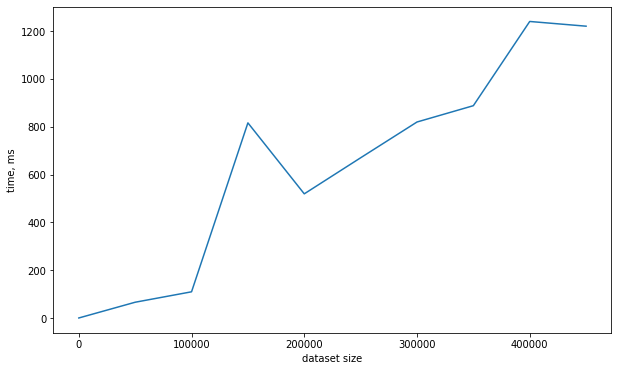

In [8]:
# sample 10, 20, ..., 100% of R
step = len(R) // 10
sizes, build_times = [], []

# tqdm_notebook draws a progress bar. If it doesnt't work in youe environment, just remove it.
for size in tqdm(range(1, len(R) + 1, step)):
    sample = R[:size]
    start = time.time()
    kdtree = Node(K=K_random).build_kd_tree(sample)
    finish = time.time()
    sizes.append(size)
    build_times.append((finish - start) * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('time, ms')
plt.plot(sizes, build_times)
plt.show()

### 1.B. Search ###
Before running this block, please complete the finction `kd_find_leaf()` which accepts a key vector and returns one leaf node, which should store this key. After you complete, you will see how fastly your queries can be processed with respect to dataset size.

/Users/jaspersw./anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


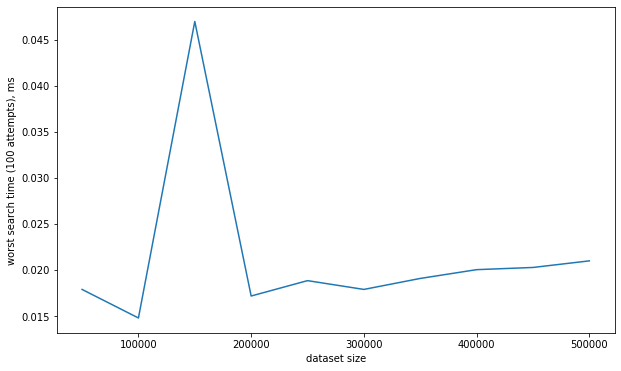

In [28]:
step = len(R) // 10
sizes, search_times = [], []

for size in tqdm_notebook(range(step, len(R) + 1, step)):
    kdtree = Node(K=K_random).build_kd_tree(R[:size])
    
    iterations = 100
    duration = None
    for i in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        start = time.time()
        kdtree.kd_find_leaf(x[0])
        finish = time.time()
        duration = max(duration, finish - start) if duration else finish - start
        
    sizes.append(size)
    search_times.append(duration * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('worst search time (100 attempts), ms')
plt.plot(sizes, search_times)
plt.show()

### 1.C. Insertion ###
One of your classmates came to me with a robotics problem. *"What if I want to insert 5000 new point per second?"* - he said. I want you to answer this question. Implement remaining part of `kd_insert_with_split()` and run the test.

In [ ]:
step = 5000
sample_size = 500000
trees = [
            Node(K=K_random), 
            Node(K=K_random), 
            Node(K=K_random)
]
capacities = [1, 4, 10]


sizes, depths = [], [[], [], []]
max_depth = [0, 0, 0]
for i in tqdm_notebook(range(0, sample_size, step)):
    for item in R[i:i+step]:
        for t in range(3):
            trees[t].kd_insert_with_split((item[0], "stub value test 1.C."), leaf_capacity=capacities[t])
            max_depth[t] = max(trees[t].kd_find_leaf(item[0]).depth, max_depth[t])
    sizes.append(i)
    for t in range(3):
        depths[t].append(max_depth[t])

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('iteration of inserting 5000 points')
a.set_ylabel('tree depth after insertions')
plt.plot(sizes, depths[0])
plt.plot(sizes, depths[1])
plt.plot(sizes, depths[2])
plt.show()

### 1.D. ANNS search ### 
This block tests `get_nn()` method, which performs approximate nearest neighbour search. Please, complete this method. After you run this block you will see how NN count influences search speed.

In [ ]:
# NN SEARCH
kdtree = Node(K=K_random).build_kd_tree(R)
times = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        kdtree.get_nn(x[0], nn)
    finish = time.time()
    times.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time of search, ms')
plt.plot(nns,times)
plt.show()

## 2. [Annoy](https://github.com/spotify/annoy) library ## 

Now you have your own index data structure. How far is it from industrial implementations?

First of all, let's install and import the requirement. Just run it.

In [10]:
!pip install --user annoy
from annoy import AnnoyIndex

     |████████████████████████████████| 645kB 305kB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.16.2-cp37-cp37m-macosx_10_9_x86_64.whl size=69133 sha256=e6602f84ccffdcb10015ad2628598d7c82b8e278724ba29d117b03c1a9e12e05
  Stored in directory: /Users/jaspersw./Library/Caches/pip/wheels/d3/d7/68/3795670ef4c6781fc10df0d6cf83b922244aa28cd9489d1176
Successfully built annoy


In [11]:
# use Eiclidean distance for the index. Also multiple others allowed
index = AnnoyIndex(K_random, 'euclidean')

for i, row in enumerate(R):
    index.add_item(i, row[0])

index.build(10) # number of trees

# this code shows how to save the index. Loading is fast - it uses memory map (mmap) of file
# index.save('test2.ann')
# index = AnnoyIndex(dim, 'euclidean')
# u.load('test2.ann')

True

Second, let's run a test for KNN search. 

Is it much faster?

Is it assimpotically faster?

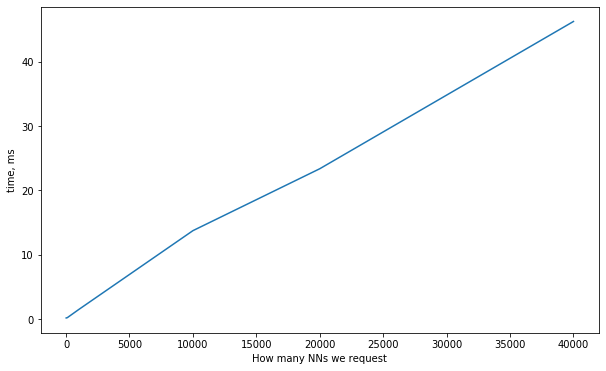

In [13]:
# NN SEARCH
times_annoy = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        index.get_nns_by_vector(x[0], nn)
    finish = time.time()
    times_annoy.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time, ms')
plt.plot(nns, times_annoy)

# you can also build times array on the same graph
#  plt.plot(nns, times)
plt.show()

## 3. Real data ##

Let's pracite on the real data. [Here are samples](https://drive.google.com/drive/folders/1nhiJC6g5R5uPDYwa-6sz9_bJ3sYGm8mM?usp=sharing) of GeoSite's database (63 countries, 21M POIs). Download and uncompress any dataset you like (or can), and load the data with pickle.

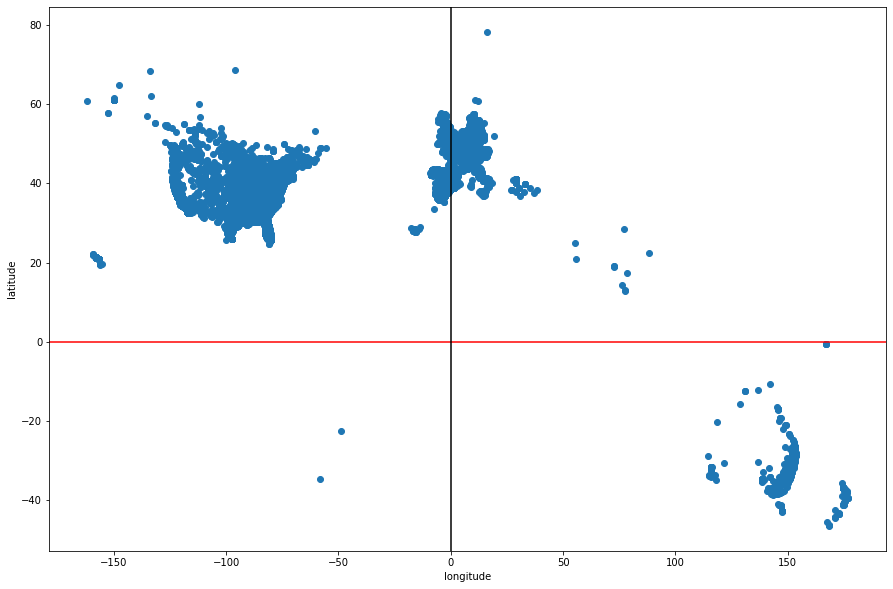

In [16]:
# replace filename if you want to use other index file
with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000
    
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

Now let's build the index on this real data. As it holds latitude and longutude, we will have `K=2`.

In [17]:
K_real = 2
start = time.time()
kdtree = Node(K=K_real).build_kd_tree(dataset)
finish = time.time()
print("Index build in {:.2f} sec.".format(finish - start))

Index build in 0.65 sec.


Check your nearest neighbours search works on real data.

In [55]:
paris = [2.334083, 48.853260]
boulder = [-105.205606, 40.063987]
sidney = [151.211122, -33.874236]

paris_nn = [v for v in kdtree.get_nn(paris, 5000) if 'Shop' in v[1]]
boulder_nn = [v for v in kdtree.get_nn(boulder, 5000) if "College" in v[1]]
sidney_nn = [v for v in kdtree.get_nn(sidney, 5000) if "Food" in v[1]]

# print to check that places you found are actually in neighbourhood
print("Australia, Sidney, food", sidney_nn[:5])

Australia, Sidney, food []


Next block will draw your results on a map.

In [ ]:
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]
BX, BY = [v[0][0] for v in boulder_nn], [v[0][1] for v in boulder_nn]
PX, PY = [v[0][0] for v in paris_nn], [v[0][1] for v in paris_nn]
SX, SY = [v[0][0] for v in sidney_nn], [v[0][1] for v in sidney_nn]
plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.scatter(BX, BY, marker="*", s=50)
plt.scatter(PX, PY, marker="^", s=50, color="orange")
plt.scatter(SX, SY, marker="+", s=50, color='yellow')
plt.show()

## 3.B. Range search ##
Range search in kd-tree is based on the idea, that we skip branches that do not intersect search range. You can use comparison with `pivot` element to decide. Please write your code in `get_in_range()` method. It accepts 2 vector keys of lower and upper bounds.

Then run 2 following blocks to see if it works. At the map it should be a region on the East coast of US.

In [ ]:
low, high = [-76.0, 38.0], [-72.0, 42.0]
region = kdtree.get_in_range(low, high)
print("Found: {} items".format(len(region)))

In [ ]:
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]
RX, RY = [v[0][0] for v in region], [v[0][1] for v in region]
plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.scatter(RX, RY, marker=".", s=50)
plt.show()

## 4. [OPTIONAL] Open questions ##
Change your code to answer:
1. How `K` parameter influences kd-tree search speed?
2. How `K` parameter influences Annoy search speed?
3. How branch split technique (pivot selection) influence tree depth?
4. How range size and `K` parameter influence range search in kd-tree?